<a href="https://colab.research.google.com/github/gon-olmedo/data-science-cookbook/blob/main/Times_Series_Forecasting/04_Autoregressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
# let's get some data

file = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/foot_traffic.csv'

df = pd.read_csv(file)

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


In [3]:
# transform index into dates

# set the start date
start_dt = '2000-01-01'

# create an array of the start date repeated as needed
start_dates = np.full(shape=len(df.index),
                      fill_value=start_dt,
                      dtype=np.dtype('datetime64[ns]'))

# to each date of the array add the corresponding int from index
dates = start_dates + pd.to_timedelta(df.index, unit='W')

# assign back to original df
df.index = dates

# Since we know the time frequncy of th index is daily, we can set it up
# it will come in handy for timeseries analysis later and avoid warnings
df.index.freq = 'W-SAT'

# Voila
df.head()

,foot_traffic
2000-01-01,500.496714
2000-01-08,500.522366
2000-01-15,501.426876
2000-01-22,503.295990
2000-01-29,504.132695


In [4]:
# plot it
fig = px.line(df, x=df.index, y='foot_traffic')

fig.update_yaxes(title='Average weekly foot traffic')
fig.update_xaxes(title='Time')

fig.show()

# Test for Stationary

In [5]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-Value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
P-Value: 0.683880891789619


The above is not a large negative number and neither the P-Value is belo 0.05, we need to transform

# Differentiation

In [6]:
foot_traffic_diff = df.diff(periods=1)
foot_traffic_diff.head()

,foot_traffic
2000-01-01,NaN
2000-01-08,0.025651
2000-01-15,0.904511
2000-01-22,1.869114
2000-01-29,0.836705


In [7]:
# since we loose the fisrt row in diff (n=1) we will cut down our df
df_diff = foot_traffic_diff[1:]

# check
df_diff.head()

,foot_traffic
2000-01-08,0.025651
2000-01-15,0.904511
2000-01-22,1.869114
2000-01-29,0.836705
2000-02-05,1.039848


In [8]:
# chart it
fig = px.line(df_diff, x=df_diff.index, y='foot_traffic')

fig.update_yaxes(title='Average weekly foot traffic (difference)')
fig.update_xaxes(title='Time')

fig.show()

In [9]:
# test ADF

ADF_result = adfuller(df_diff) # do not read first element since in NaN

print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-Value: {ADF_result[1]}')

ADF Statistic: -5.268231347422044
P-Value: 6.369317654781239e-06


ADF is a large negative and p-value is below 0.05, we can reject H0 and moe formward

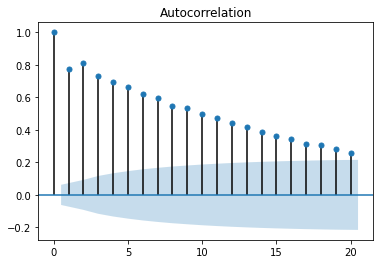

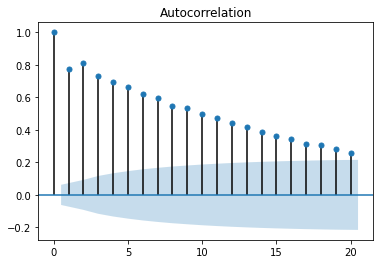

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_diff, lags=20)

The autocorrelation drops exponentially with lags, it seems that we have not a MA but probably an autoregressive process, we will need to test further to see if this is true

# The partial autocorrelation function (PACF)

In [11]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

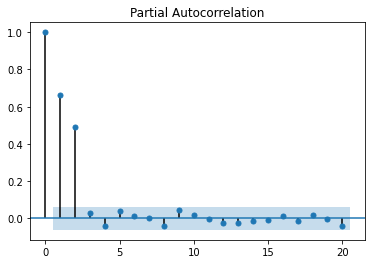

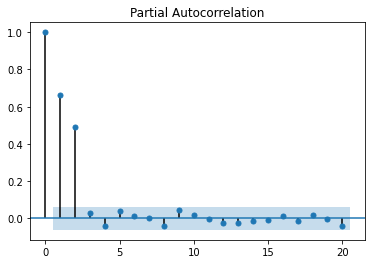

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)

As we can see from the above, after lag 2, there the autocorrelations drops to be non-significative

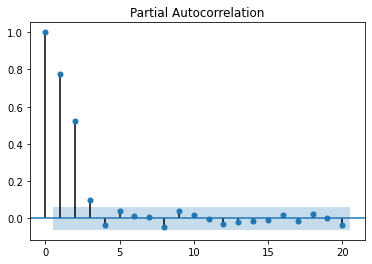

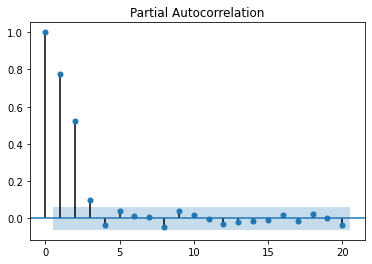

In [13]:
plot_pacf(df_diff, lags=20)

# Forecasting an autoregressive process

In [14]:
# we will train then the df_diff

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test)) 


# plot data
fig = px.line(df_diff, x=df_diff.index, y='foot_traffic')

# higliht test range
fig.add_vrect(x0=df_diff.index[-52], x1=df_diff.index[-1], line_width=0, fillcolor="grey", opacity=0.2)

fig.show()

947
52


In [15]:
# we will chart multiple charts in the same figure so we need subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [16]:
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True)

# set each graph
fig.add_trace(go
              .Scatter(x=df.index, y=df['foot_traffic']),
              row=1, col=1
              )

fig.add_trace(go
              .Scatter(x=df_diff.index, y=df_diff['foot_traffic']),
              row=2, col=1
              )

# Update axes
fig.update_yaxes(title_text='Average weekly<br>foot traffic', row=1, col=1)
fig.update_yaxes(title_text='Average weekly<br>foot traffic (difference)', row=2, col=1)
fig.update_xaxes(title='Time', row=2, col=1)

# add higlighter for test data
fig.add_vrect(x0=df_diff.index[-52], x1=df_diff.index[-1],
              annotation_text='Test', annotation_position='outside top right',
              line_width=0, fillcolor="grey", opacity=0.2)

fig.update_layout(showlegend=False)

fig.show()

In [17]:
# forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
 
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [19]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
 
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')    
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')
 
test.insert(loc=test.shape[1], column='pred_mean', value=pred_mean)
test.insert(loc=test.shape[1], column='pred_last_value', value=pred_last_value)
test.insert(loc=test.shape[1], column='pred_AR', value=pred_AR)
 
test.head()

,foot_traffic,pred_mean,pred_last_value,pred_AR
2018-03-03,-0.776601,0.213270,-1.021893,-0.719714
2018-03-10,-0.574631,0.212226,-0.776601,-0.814547
2018-03-17,-0.890697,0.211397,-0.574631,-0.664738
2018-03-24,-0.283552,0.210237,-0.890697,-0.641469
2018-03-31,-1.830685,0.209717,-0.283552,-0.579279


In [20]:
# let's plot the predictions

# prepare df instead of selecting each
columns = test.columns

melt_test = pd.melt(test.reset_index(), id_vars='index',
                    value_vars=columns)

melt_test.head()

,index,variable,value
0,2018-03-03,foot_traffic,-0.776601
1,2018-03-10,foot_traffic,-0.574631
2,2018-03-17,foot_traffic,-0.890697
3,2018-03-24,foot_traffic,-0.283552
4,2018-03-31,foot_traffic,-1.830685


In [21]:
columns = train.columns

melt_train = pd.melt(train.reset_index(), id_vars='index', value_vars=train.columns)

melt_train.head()

,index,variable,value
0,2000-01-08,foot_traffic,0.025651
1,2000-01-15,foot_traffic,0.904511
2,2000-01-22,foot_traffic,1.869114
3,2000-01-29,foot_traffic,0.836705
4,2000-02-05,foot_traffic,1.039848


In [22]:
pred_df = pd.concat([melt_train, melt_test], axis=0)

var_map = {'foot_traffic': 'Actual',
           'pred_mean': 'Mean',
           'pred_last_value': 'Last',
           'pred_AR': 'AR(3)'}

pred_df['variable'] = pred_df['variable'].map(var_map)

pred_df.rename(columns={'index':'date'}, inplace=True)

pred_df.tail()

,date,variable,value
203,2019-01-26,AR(3),-2.040021
204,2019-02-02,AR(3),-2.204371
205,2019-02-09,AR(3),-1.514693
206,2019-02-16,AR(3),-0.690131
207,2019-02-23,AR(3),-0.834148


In [35]:
# it's chart time
# let's use only date from 2017

fig = px.line(pred_df.query('date >= "2017-01-01"'),
              x='date', y='value', color='variable', line_dash='variable')

fig.update_xaxes(title='Date')
fig.update_yaxes(title='Average weekly foot traffic (difference)')

fig.add_vrect(x0=test.index[0], x1=test.index[-1],
              line_width=0, fillcolor="grey", opacity=0.2,
              annotation_text='Prediction Range', annotation_position='top left')

fig.show()

In [24]:
pred_df['variable'].value_counts(dropna=False)

Actual    999
Mean       52
Last       52
AR(3)      52
Name: variable, dtype: int64

In [41]:
#
from sklearn.metrics import mean_squared_error
 
mse_mean = mean_squared_error(test['foot_traffic'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic'], test['pred_AR'])
 
print(mse_mean, mse_last, mse_AR)

fig = px.bar(x=['Mean', 'Last', 'AR(3)'], y=[mse_mean, mse_last, mse_AR])

fig.update_traces(texttemplate="%{y:.2f}", # show value on labels formatted as .2f
                  textposition='outside') # labels to be outsid eof the bars

fig.show()

3.1079979374701447 1.448730118495964 0.9242479163733789
